In [1]:
import numpy as np
import matplotlib.pyplot as plt
from laserfields import make_laserfield, LaserFieldCollection

In [2]:
import ipywidgets as ipw
%matplotlib widget

In [3]:
plt.style.use('https://johannesfeist.eu/misc/jf_cb.mplstyle')

# Introduction to Laserfields library
The laserfields library is a small library (available in [Fortran](https://github.com/jfeist/laserfields), [Python](https://github.com/jfeist/pylaserfields), and [Julia](https://github.com/jfeist/LaserFields.jl)) that provides classes to represent time-dependent laser pulses as typical in ultrafast physics & chemistry, and easily obtain their temporal fields and analytical Fourier transforms, as well as accessing either the electric field or vector potential, etc. The "main" function is `make_laserfield`, which accepts a series of keyword parameters to define a pulsed laser field. The general form of the fields is always
\begin{equation}
F(t) = F_0 C(t_r) \sin(\phi_0 + \omega_0 t_r + c t_r^2)
\end{equation}
where $t_r = t - t_0$ and
- $t_0$ is the peak time of the pulse,
- $F_0$ is the peak amplitude,
- $C(t)$ is an envelope function that describes the global shape of the pulse (and is normalized so that $C(0)=1$),
- $\phi_0$ is a constant phase shift,
- $\omega_0$ is the central ("carrier") frequency, and
- $c$ is a possible linear chirp rate.

There are many different possibilities for the envelope function $C(t)$. We also note that the interface of the Python and Julia versions of the library is somewhat more flexible than the Fortran version. The discussion below applies to those versions (which are virtually identical in features).


## Units
`make_laserfield` accepts a flexible set of parameters to specify the pulses. There are two options it offers for handling units: One is to directly pass values for the parameters in arbitrary units, which laserfields maintains. The user is then responsible to make sure that the input is consistent (i.e., that frequencies and times are given in inverse units of each other), and that the output is used consistently. The other option is to pass input parameters in some common specific units (described below), which are then automatically converted to Hartree atomic units for the "actual" parameters.

In the examples here, we will use the library in the "bare" mode where we give the input parameters directly in the units we want to use.

## Input parameters
- `form`: String describing the form (temporal shape) of the field. Options are:
    - `"gaussianF"`, `"gaussianI"`: Gaussian envelopes $C(t) = e^{-t^2/T^2}$
    - `"sin2"`, `"sin4"`, `"sin_exp"`: Sine raised to a power, $C(t) = \sin^n\left(\pi \frac{t-t_0-T/2}{T}\right)$ for $t_0-T/2<t<t_0+T/2$ and zero otherwise.
      `"sin2"` sets $n=2$, `"sin4"` sets $n=4$, and `"sin_exp"` needs an extra argument `"form_exponent"` to `make_laserfield` to set $n$.
    - `"linear"`, `"linear2"`: Flat top laser field that is turned on over a time $T_{ramp}$ (either linearly (`"linear"`) or with a $\sin^2$ rampon (`"linear2"`)), then stays constant over a time $T_{flat}$, and then is turned off smoothly again.
    - `"readin"`: Field read in from a data file (specified by the `"datafile"` parameter) and evaluated by interpolation (no other parameters should be set in this case).

- `is_vecpot`: Boolean (`True` or `False`) the specifies whether the analytical form describes the vector potential $A(t)$ (`True`) or the electric field $E(t)$ (`False`).
  Describing the vector potential is advantageous since the two are related by $E(t) = -\frac{\mathrm{d}A(t)}{\mathrm{d}t}$, and derivation is always possible in closed form, such that $E(t)$ can be analytically obtained if $A(t)$ is given, while $A(t)$ is not generally available if $E(t)$ is defined. Furthermore, propagating pulses must fulfill the condition $A(t_i) = A(t_f)$, which is not automatically fulfilled if $E(t)$ is defined (especially for very short pulses).
- `E0` or `intensity_Wcm2` defines the peak electric field strength. If `intensity_Wcm^2` is passed, this is the intensity in $W/cm^2$ and is converted to peak electric field strength $E_0$ in $a.u.$. If `E0` is passed directly, its value is used without conversion. If `is_vecpot=True`, the peak vector potential $A_0$ is given by $E_0/\omega_0$.
- `ω0`, `omega` or `lambda_nm`: `ω0` and `omega` are interchangeable and set the carrier frequency directly, `lambda_nm` is the wavelength in nanometers and is converted to frequency in a.u.
- `φ0`, `ϕ0` (entered as `\phi` and `\varphi`) are interchangeable and set the constant phase shift $\phi_0$, `phase_pi` is the same in units of $\pi$ (i.e., $\phi_0 = \mathrm{phase\_pi} \pi$. Default value is $\phi_0=0$.
- `chirp` or `linear_chirp_rate_w0as`: Define the chirp rate $c$ directly, or in units of $\omega_0$ per attosecond (where time is assumed to be in a.u.), i.e. $c = \mathrm{linear\_chirp\_rate\_w0as} \omega_0 / \mathrm{au_as}$. Default value is $c=0$.
- `t0`, `peak_time`, `peak_time_as`: Set the peak time $t_0$ of the pulse (directly with `t0`, `peak_time`, or converted to a.u. for input in attoseconds with `peak_time_as`).
- `duration` or `duration_as`: Set the duration of the pulse directly, or converted to a.u. for input in attoseconds. Note that the meaning of `duration` depends on the chosen `form` in the following way:
     - `"gaussianF"`: Full width at half maximum (FWHM) of the electric field of the pulse
     - `"gaussianI"`: FWHM of the intensity of the pulse (this is the value typically specified by experimentalists).
     - `"sin2"`,`"sin4"`,`"sin_exp"`: total duration $T$ of pulse (i.e., goes from $t_0 - T/2$ to $t_0 + T/2$). Note that $T$ is much longer than what one usually calls the "duration" of a pulse (FWHM of intensity). E.g., a `"sin2"` pulse with `duration_as = 1000` corresponds to FWHM of the intensity of $\approx 364$ as.
- `Tramp`, `rampon`, `rampon_as`: Rampon time for `"linear"` and `"linear2"` pulses (`Tramp` and `rampon` are equivalent, `rampon_as` is converted to a.u. for input in attoseconds).

## Return value
`lf = make_laserfield(...)` returns a `LaserField` object that can be directly called to obtain the electric field at time `t`, `E = lf(t)`, and offers various member functions to access the electric field `E = lf.E(t)`, vector potential `A = lf.A(t)`, their Fourier transforms `Eω = lf.E_fourier(ω)` and `Aω = lf.A_fourier(ω)`, the times when the pulse starts (`lf.start_time`) and ends (`lf.end_time`), as well as the envelope $F_0 C(t)$ (`env = lf.envelope(t)`), the oscillation period `lf.TX` ($=2\pi/\omega_0$), etc.

# Fourier transform - quick overview
For any (integrable) function $g(t)$, the Fourier transform is defined as 
\begin{equation}
\tilde{g}(\omega) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^\infty e^{-i\omega t} g(t) \mathrm{d}t
\end{equation}
and from it follows the inverse Fourier transform
\begin{equation}
g(t) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^\infty e^{i\omega t} \tilde{g}(\omega) \mathrm{d}\omega
\end{equation}
Note that there are many conventions in use (regarding the prefactors, the sign of the exponent, whether angular frequency $\omega$ or normal frequency $f$ is used, etc). The convention here ensures unitarity, i.e., it conserves the norm of the function:
\begin{equation}
\int_{-\infty}^\infty |g(t)|^2 \mathrm{d}t = \int_{-\infty}^\infty |\tilde{g}(\omega)|^2 \mathrm{d}\omega
\end{equation}
The Fourier transform can be viewed as saying that any function $g(t)$ can be decomposed/understood as a sum (or rather, continuous sum, i.e., integral) of plane waves $e^{i\omega t}$ with coefficients $\tilde{g}(\omega)$. This means that any function in time is fully characterized by its frequency components. However, note that in general, the Fourier transform $\tilde{g}(\omega)$ is complex even if $g(t)$ is real. However, a useful relation in that case is that $\tilde{g}(-\omega) = \tilde{g}(\omega)^*$ (if $g(t)$ is purely real), i.e., the negative and positive-frequency components are related by complex conjugation.
The complex value of the Fourier transform also means that we do not get the full information if we only plot, e.g., the real part or the absolute value. Usually, it is most useful to represent Fourier transforms in terms of the modulus $|\tilde{g}(\omega)|$ and phase $\arg\tilde{g}(\omega)$ (i.e., $\tilde{g}(\omega) = |\tilde{g}(\omega)| e^{i \arg\tilde{g}(\omega)}$. Conceptually, the modulus gives information about what frequencies are contained in the pulse (i.e., its frequency spectrum), while the phase gives information about their temporal relation. Note that pulses with the same spectrum but different phases can have completely different shapes in time.

# One field
We start with a simple example: One laser field, and plot both its time-dependent field and Fourier transform. As discussed above, we plot both the modulus squared $|\tilde{E}(\omega)|^2$ (which corresponds to the power spectrum of the pulse) and phase $\arg{\tilde{E}(\omega)}$. We note that since $E(t)$ and $A(t)$ are real functions, the Fourier transforms fulfill $\tilde{E}(-\omega) = \tilde{E}(\omega)^*$, i.e., all information is contained in either the positive or negative frequency components, and we just plot the positive ones.

We define a convenience function `plot_lf_field_fourier` to plot the electric field and its Fourier transform for `LaserField` objects.

In [47]:
def plot_lf_field_fourier(lf,ts,ωs,log_four=False,plot_phase=True,figaxs=None):
    if figaxs is None:
        fig, axs = plt.subplots(1,2,figsize=(10,4))
        if plot_phase:
            axs = np.r_[axs, axs[1].twinx()]  # instantiate a second axes that shares the same x-axis
    else:
        fig, axs = figaxs
    axs[0].plot(ts,lf(ts))
    try:
        axs[0].plot(ts,lf.envelope(ts),'C0--')
    except:
        pass
    axs[0].set_xlabel("t (a.u.)")
    axs[0].set_ylabel("E(t) (a.u.)")

    try:
        Eω = lf.E_fourier(ωs)
    except NotImplementedError:
        Eω = np.zeros_like(ωs)
        
    axs[1].plot(ωs,abs(Eω)**2)
    axs[1].set_xlabel(r"$\omega$ (a.u.)")
    axs[1].set_ylabel(r"$|\tilde{E}(\omega)|^2$ (a.u.)")
    if log_four:
        axs[1].set_ylim(1e-6*abs(Eω).max()**2)
        axs[1].set_yscale("log")
    else:
        axs[1].set_ylim(0,)
    if plot_phase:
        axs[2].plot(ωs,np.angle(Eω)/np.pi,'C1')
        axs[2].set_ylim(-1.05,1.05)
        axs[2].set_ylabel(r"$\arg \tilde{E}(\omega) / \pi$")
    
    for ax in axs:
        ax.autoscale(axis="x",tight=True)

    return fig, axs

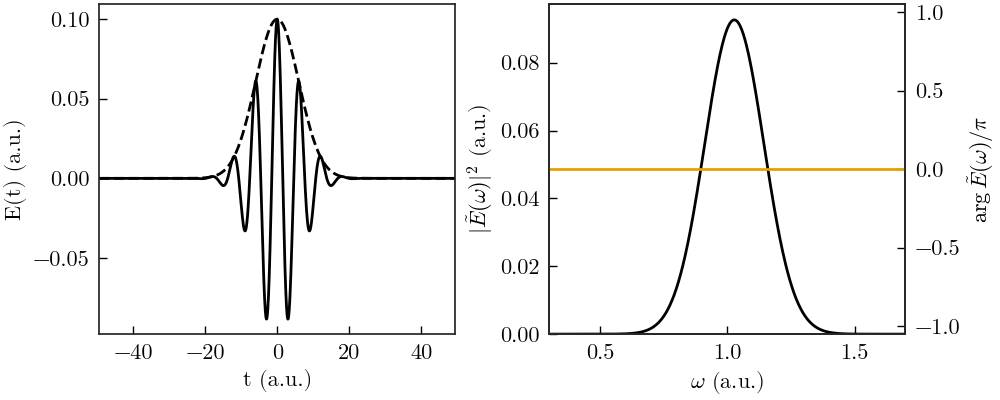

In [49]:
lf = make_laserfield(form="gaussianI", is_vecpot=True, duration=10, ω0=1., E0=0.1, t0=0, phase_pi=1)
# use a linear grid in time with 100 points per laser period TX
ts = np.arange(lf.start_time, lf.end_time, lf.TX/100)
ωs = np.linspace(0.3,1.7,500)

plot_lf_field_fourier(lf,ts,ωs);

## Exercise:
**Plot fields with different shapes, durations, central frequencies, peak times.** In particular, explore how:
1. The duration in time and spectral bandwidth in frequency are related. Does this remind you of something?
2. What changes in the Fourier transform when the peak time $t_0$ is changed. Do you understand why?
3. How the shape of the Fourier transform changes for the different available pulse shapes (pass `log_four=True` to `plot_lf_field_fourier` to plot $|\tilde{E}(\omega)|^2$ on a logarithmic scale).
4. How using `is_vecpot=True` or `False` affects the temporal field and Fourier transform. Tip: Try (very) short pulses and pay attention to whether the maximum of the Fourier transform $|\tilde{E}(\omega)|^2$ coincides with $\omega_0$. Do you understand what is going on?
5. How adding a (temporal) chirp affects the field and the phase of the pulse.

interactive(children=(Checkbox(value=True, description='is_vecpot'), Dropdown(description='form', options=('ga…

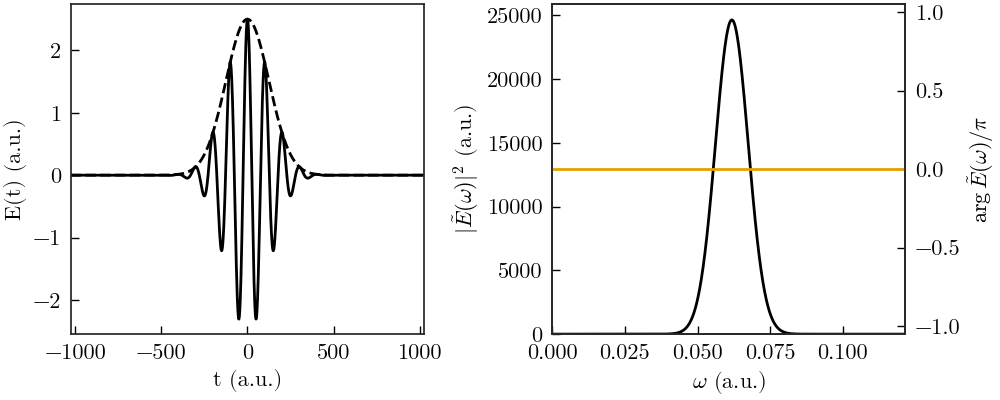

In [50]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
axs = np.r_[axs, axs[1].twinx()]  # instantiate a second axes that shares the same x-axis

@ipw.interact(is_vecpot=True,form=["gaussianI","gaussianF","sin2","sin4","linear", "linear2"],
              lambda_nm=(1,1500), E0=(0,5.), duration_as=(30.,10000.), peak_time_as=(-10000.,10000.),
              rampon_as = (0,5000.), phase_pi=(0.,2.), linear_chirp_rate_w0as_x1e6=(-100.,100.), log_four=False)
def f(is_vecpot, form, lambda_nm, E0, peak_time_as, duration_as, rampon_as, phase_pi, linear_chirp_rate_w0as_x1e6, log_four):
    lf = make_laserfield(form=form, is_vecpot=is_vecpot, duration_as=duration_as, rampon_as=rampon_as,
                         lambda_nm=lambda_nm, E0=E0, peak_time_as=peak_time_as, phase_pi=phase_pi,
                         linear_chirp_rate_w0as=linear_chirp_rate_w0as_x1e6*1e-6)
    # use a linear grid in time with 100 points per laser period TX
    ts = np.arange(lf.start_time, lf.end_time, lf.TX/100)
    ωs = np.linspace(0,2*lf.ω0,1000)

    # clear axes 0 and 1, and make a new axs[2] (since clearing a twinned axis 
    # also clears the information that the y-axis label should go on the right)
    axs[0].cla()
    axs[1].cla()
    axs[2].remove()
    axs[2] = axs[1].twinx()
    
    plot_lf_field_fourier(lf,ts,ωs,log_four=log_four,plot_phase=True,figaxs=(fig,axs))

## Frequency chirps - [chirped pulse amplification](https://en.wikipedia.org/wiki/Chirped_pulse_amplification) (CPA)
We here study the basis of the CPA technique that enabled the development of highly intense ultrashort lasers and for which Donna Strickland and Gérard Mourou were awarded the Nobel Prize in Physics in 2018. We introduce a chirp in frequency while maintaining the frequency spectrum of the pulse. This is a short analytical calculation for Gaussian pulses.

interactive(children=(FloatSlider(value=0.0, description='g', max=500.0, min=-500.0), Output()), _dom_classes=…

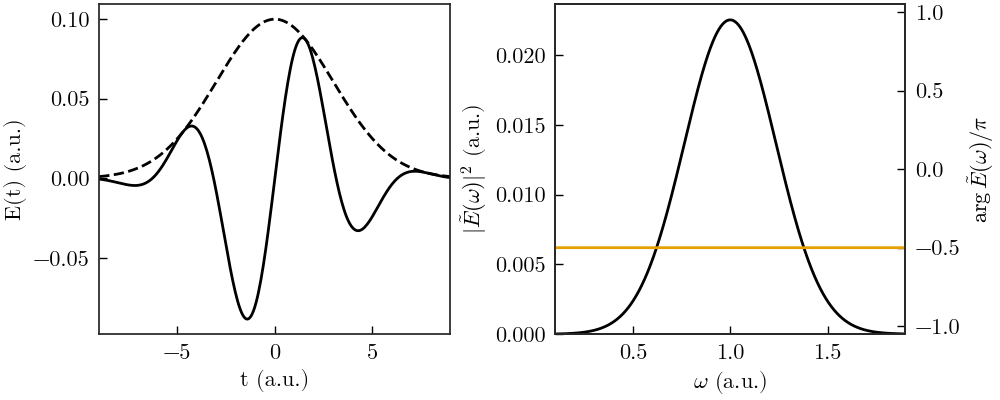

In [59]:
def lf_chirped(lf,g):
    σg = np.sqrt(lf.σ**2 + g**2/lf.σ**2)
    return make_laserfield(form="gaussianI", is_vecpot=False, duration=σg*np.sqrt(np.log(16)),
                           ω0=lf.ω0, E0=lf.E0*np.sqrt(lf.σ/σg), t0=lf.t0,
                           φ0=-0.5*np.angle(lf.σ**2 - 1j*g), chirp=-0.5*g/(lf.σ*σg)**2)

lf = make_laserfield(form="gaussianI", is_vecpot=False, duration=5, ω0=1., E0=0.1, t0=0, phase_pi=0)

ωs = np.linspace(0.1,1.9,50000)

fig, axs = plt.subplots(1,2,figsize=(10,4))
axs = np.r_[axs, axs[1].twinx()]  # instantiate a second axes that shares the same x-axis

@ipw.interact(g=(-500.,500.))
def f(g=0):
    lf_c = lf_chirped(lf,g)
    # use a linear grid in time with 100 points per laser period TX
    ts = np.arange(-3*lf_c.σ, 3*lf_c.σ, lf.TX/100)    

    axs[0].cla()
    axs[1].cla()
    axs[2].remove()
    axs[2] = axs[1].twinx()

    plot_lf_field_fourier(lf_c,ts,ωs,figaxs=(fig,axs))

# Two fields - interference in time and frequency
In this section, we will explore how having two pulses together affects the temporal field and Fourier transform for different cases.

The convenience class `LaserFieldCollection` describes a field that is the sum of several `LaserField` objects.

Note that the Fourier transform is a linear operation, i.e., the Fourier transform of $E(t) = E_1(t) + E_2(t)$ is given by $\tilde{E}(\omega) = \tilde{E}_1(\omega) + \tilde{E}_2(\omega)$.

## In time

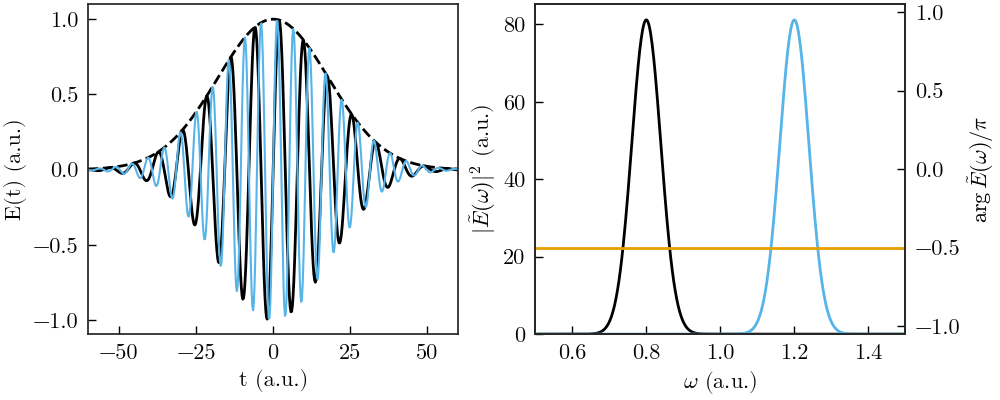

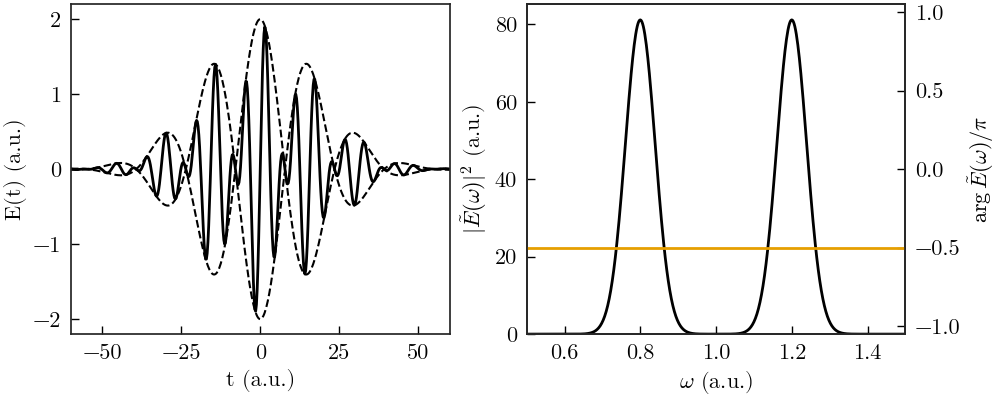

In [11]:
lf1 = make_laserfield(form="gaussianI",is_vecpot=False,ω0=0.8,duration=30.,E0=1,t0=0.)
lf2 = make_laserfield(form="gaussianI",is_vecpot=False,ω0=1.2,duration=30.,E0=1,t0=0.)
lfc = LaserFieldCollection([lf1,lf2])
Δω = lf2.ω0 - lf1.ω0

ts = np.linspace(-60,60,501)
ωs = np.linspace(0.5,1.5,501)

fig,axs = plot_lf_field_fourier(lf1,ts,ωs)
axs[0].plot(ts,lf2.E(ts),'C2',lw=1.5)
axs[1].plot(ωs,abs(lf2.E_fourier(ωs))**2,'C2')

fig,axs = plot_lf_field_fourier(lfc,ts,ωs)
axs[0].plot(ts, lf1.envelope(ts)*abs(1+np.exp(-1j*Δω*ts)),'C0--',lw=1.5)
axs[0].plot(ts,-lf1.envelope(ts)*abs(1+np.exp(-1j*Δω*ts)),'C0--',lw=1.5);

## In frequency

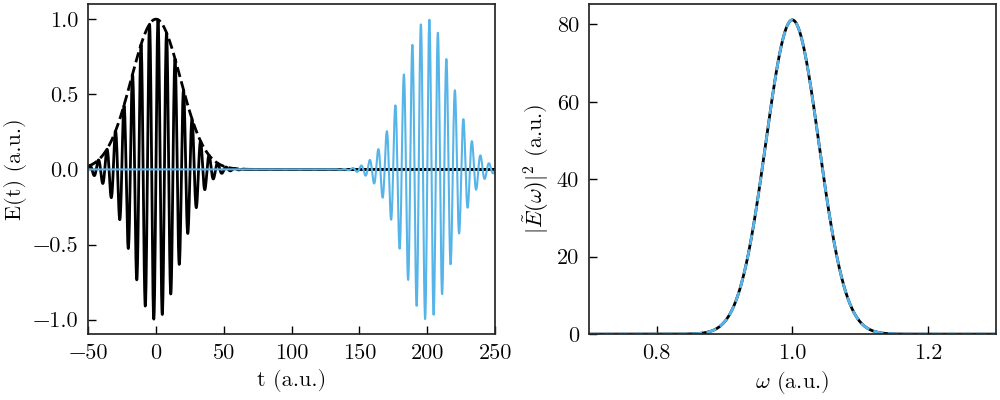

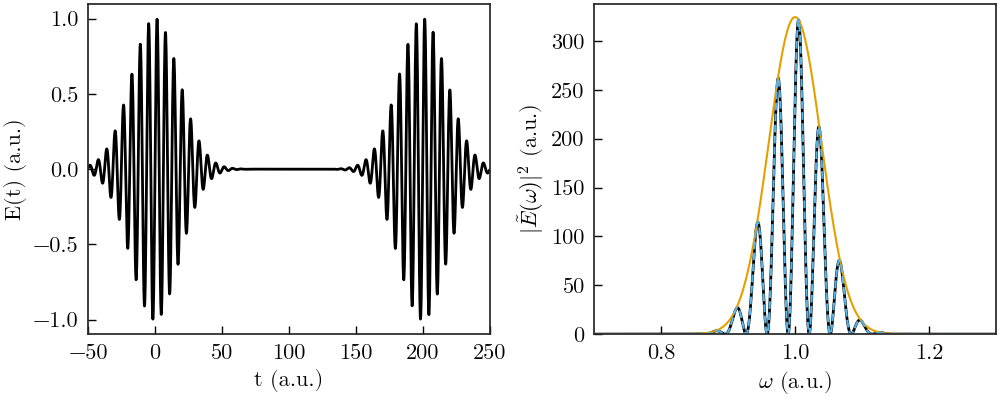

In [60]:
lf1 = make_laserfield(form="gaussianI",is_vecpot=False,ω0=1.,duration=30.,E0=1,t0=0.)
lf2 = make_laserfield(form="gaussianI",is_vecpot=False,ω0=1.,duration=30.,E0=1,t0=200.)
lfc = LaserFieldCollection([lf1,lf2])
Δt = lf2.t0 - lf1.t0

ts = np.linspace(-50,250,2001)
ωs = np.linspace(0.7,1.3,2001)

fig,axs = plot_lf_field_fourier(lf1,ts,ωs,plot_phase=False)
axs[0].plot(ts,lf2.E(ts),'C2',lw=1.5)
axs[1].plot(ωs,abs(lf2.E_fourier(ωs))**2,'C2--')

fig,axs = plot_lf_field_fourier(lfc,ts,ωs,plot_phase=False)
axs[1].plot(ωs,abs(2*lf1.E_fourier(ωs))**2,lw=1.5)
axs[1].plot(ωs,abs(lf1.E_fourier(ωs)*(1+np.exp(-1j*ωs*Δt)))**2,'--',lw=1.5);

## Exercise:
**Plot different combinations of two pulses.** In particular, explore how:
1. For two pulses with the same frequency, how does the interference pattern in the Fourier transform depend on delay between the pulses? Do you understand why? (Remember the phase of the transform of a single pulse when the delay is changed).
2. Explore how the interference patterns change if the constant phase (`phase_pi` in units of pi) of one of the pulses is changed. Do this both for the "time" as well as the "frequency" interference.

In [ ]:
## PLAY AROUND HERE

# Train of pulses
Let's now make a train of ultrashort pulses with a fixed repetition rate.

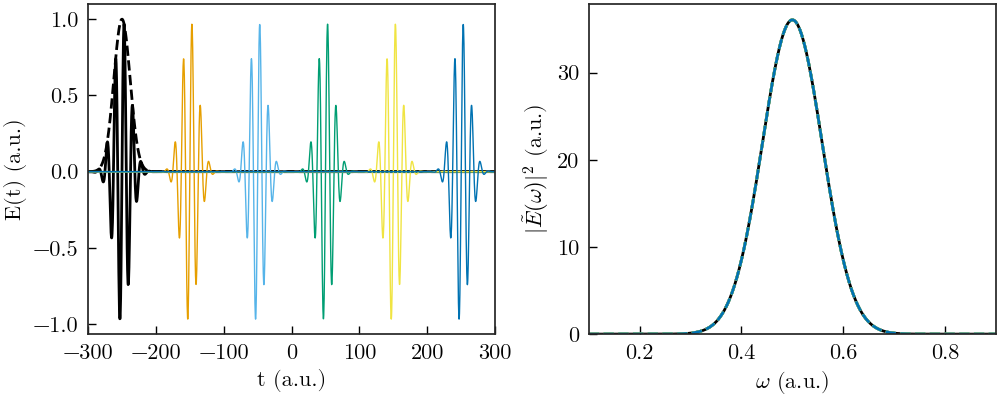

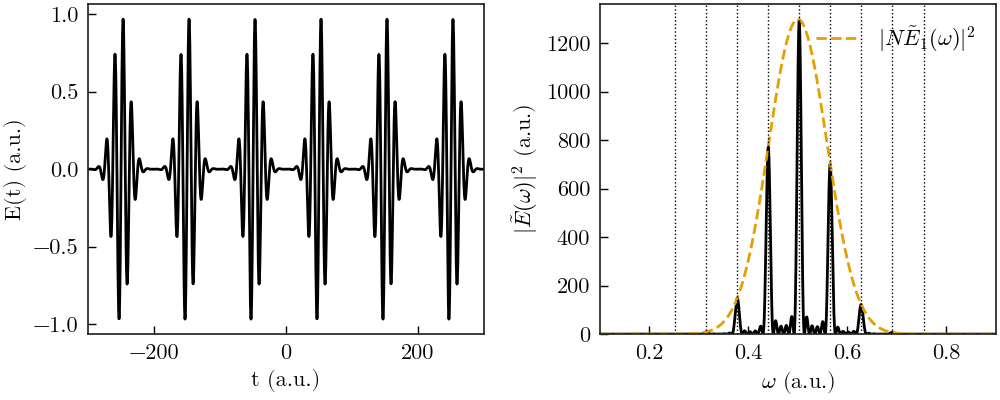

In [13]:
t0s = np.arange(-250,251,100)
lfs = []
for t0 in t0s:
    lfs.append(make_laserfield(form="gaussianI",is_vecpot=False,ω0=0.5,duration=20.,E0=1,t0=t0))
lfc = LaserFieldCollection(lfs)

ts = np.linspace(-300,300,2001)
ωs = np.linspace(0.1,0.9,2001)

fig,axs = plot_lf_field_fourier(lfs[0],ts,ωs,plot_phase=False)
for lf in lfs[1:]:
    axs[0].plot(ts,lf.E(ts),lw=1)
    axs[1].plot(ωs,abs(lf.E_fourier(ωs))**2,'--')
    
fig,axs = plot_lf_field_fourier(lfc,ts,ωs,plot_phase=False)
axs[1].plot(ωs,abs(len(lfs)*lfs[0].E_fourier(ωs))**2,'--',label=r"$|N \tilde{E}_1(\omega)|^2$")
axs[1].legend(loc="upper right");

ω0s = np.arange(8*np.pi/100,0.8,2*np.pi/100)
for ω0 in ω0s:
    plt.axvline(ω0,ls=':',lw=1,color='k')

lfs_train = lfs

Instead of a train of repeated ultrashort pulses, make a sum over long pulses at the frequencies where the train had peaks in the Fourier transform (and with the same peak amplitudes).

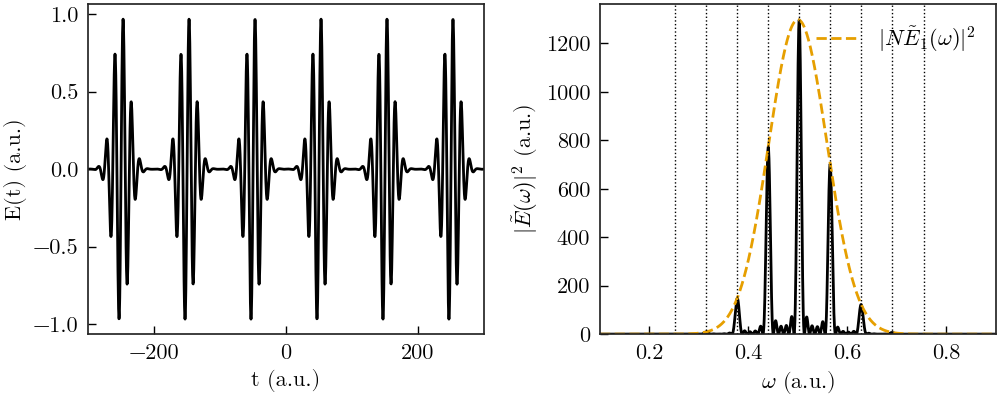

In [14]:
lfpulse = make_laserfield(form="gaussianI",is_vecpot=False,ω0=0.5,duration=20.,E0=1,t0=0)

ω0s = np.arange(8*np.pi/100,0.8,2*np.pi/100)
E0s = abs(lfpulse.E_fourier(ω0s))
E0s /= np.sum(E0s)

lfs = []
for ω0,E0 in zip(ω0s,E0s):
    lfs.append(make_laserfield(form="linear",is_vecpot=False,ω0=ω0,duration=600.,E0=E0,t0=0,Tramp=0,φ0=ω0*50))
lfc = LaserFieldCollection(lfs)

ts = np.linspace(-300,300,2001)
ωs = np.linspace(0.1,0.9,2001)

fig,axs = plot_lf_field_fourier(lfc,ts,ωs,plot_phase=False)
axs[1].plot(ωs,abs(len(lfs_train)*lfs_train[0].E_fourier(ωs))**2,'--',label=r"$|N \tilde{E}_1(\omega)|^2$")
axs[1].legend(loc="upper right");

ω0s = np.arange(8*np.pi/100,0.8,2*np.pi/100)
for ω0 in ω0s:
    plt.axvline(ω0,ls=':',lw=1,color='k')

## Exercise:
**Plot different trains.** In particular, explore:
1. How the bandwidth of the lines depends on the number of included pulses.
2. What changes in the train if the phase of every second pulse is changed by a factor $\pi$ (i.e., its sign is flipped).